# Face Generation

This notebook creates a generative adversarial network (GAN) to generate new images of human faces. The GAN is tranied using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html).

### Pre-processed Data

You can download this data [from here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [1]:
data_dir = 'processed_celeba_small/'

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since we're going to be generating faces, we won't need the annotations, we'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

In [2]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [3]:
from torch.utils.data import DataLoader
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size), # resize to 128x128
                                    transforms.ToTensor()])
    # define datasets using ImageFolder
    dataset = datasets.ImageFolder(data_dir, transform)
    
    # create and return DataLoaders
    loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    return loader


## DataLoader

In [7]:
# Define function hyperparameters
batch_size = 32
img_size = 32

celeba_train_loader = get_dataloader(batch_size, img_size)

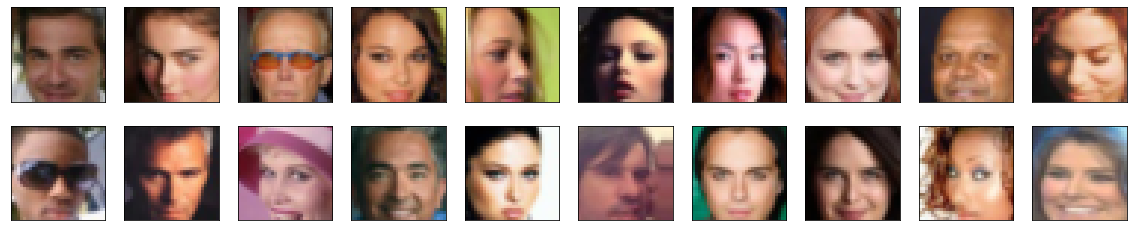

In [8]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Rescale data

Let's rescale the data to -1 to 1 as the output of tanh generator will contain pixel values from -1 to 1.


In [9]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x


In [10]:

# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9922)
Max:  tensor(0.9373)


---
# Define the Model


## Discriminator

The discrminator is trained to differentiate between real and fake images

In [11]:
import torch.nn as nn
import torch.nn.functional as F

In [12]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)
    
    dropout=torch.nn.Dropout(p=0.2)
    
    layers.append(dropout)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [13]:

from torch.nn.functional import normalize
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        
        self.conv_dim=conv_dim
        
        self.conv1=conv(3, self.conv_dim, 4, stride=2, padding=1, batch_norm=False)
        self.conv2=conv(self.conv_dim, self.conv_dim*2, 4, stride=2, padding=1, batch_norm=True)
        self.conv3=conv(self.conv_dim*2, self.conv_dim*4, 4, stride=2, padding=1, batch_norm=True)
        self.fc=nn.Linear(4*4*conv_dim*4,1)
        self.lkrelu=nn.LeakyReLU(0.2)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        
        x=self.lkrelu(self.conv1(x))
        x=self.lkrelu(self.conv2(x))
        x=self.lkrelu(self.conv3(x))
        x=x.view(-1,4*4*self.conv_dim*4)
        x=self.fc(x)
        
        return x

## Generator

The generator upsamples an input and generates a *new* image of the same size as our training data `32x32x3`.

In [14]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [15]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        self.conv_dim=conv_dim
        # complete init function
        
        self.fc=nn.Linear(z_size,4*4*conv_dim*4)
        self.deconv1=deconv(conv_dim*4, conv_dim*2, kernel_size=4, stride=2, padding=1, batch_norm=True)
        self.deconv2=deconv(conv_dim*2, conv_dim, kernel_size=4, stride=2, padding=1, batch_norm=True)
        self.deconv3=deconv(conv_dim, 3, kernel_size=4, stride=2, padding=1, batch_norm=False)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        
        x=self.fc(x)
        x=x.view(-1,self.conv_dim*4,4,4)
        x=F.relu(self.deconv1(x))
        x=F.relu(self.deconv2(x))
        x=F.tanh(self.deconv3(x))
        
        return x

## Initialize weights


All weights are initialized from a zero-centered Normal distribution with standard deviation 0.02.

In [16]:
from torch.nn import init

def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        m.weight.data.normal_(0.0, 0.02)
        if hasattr(m.bias, 'data'):
            m.bias.data.fill_(0)
    

## Build complete network

In [17]:

def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


In [18]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): Dropout(p=0.2, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): Dropout(p=0.2, inplace=False)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): Dropout(p=0.2, inplace=False)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
  (lkrelu): LeakyReLU(negative_slope=0.2)
)

Generator(
  (fc): Linear(in_features=100, out_features=4096, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, moment

### Training on GPU

In [16]:
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses


### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 

### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

In [19]:
def real_loss(D_out,smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

## Optimizers

In [18]:
import torch.optim as optim

# params
lr =0.0004
beta1= 0.1
beta2=0.9

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator.

* The discriminator is trained by alternating on real and fake images
* The generator tries to trick the discriminator and should have an opposing loss function


In [20]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            d_optimizer.zero_grad()
            
            # 1. Train the discriminator on real images
            if train_on_gpu:
                real_images = real_images.cuda()

            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            # 2. Train with fake images

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
        

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()

            # 1. Train with fake images and flipped labels

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

In [20]:
# set number of epochs 
n_epochs = 30
from workspace_utils import active_session

# call training function
with active_session():
    losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   30] | d_loss: 1.4544 | g_loss: 1.0113
Epoch [    1/   30] | d_loss: 0.5181 | g_loss: 4.0010
Epoch [    1/   30] | d_loss: 1.1374 | g_loss: 1.2259
Epoch [    1/   30] | d_loss: 1.0261 | g_loss: 0.9928
Epoch [    1/   30] | d_loss: 1.1822 | g_loss: 0.9125
Epoch [    1/   30] | d_loss: 1.0435 | g_loss: 1.5491
Epoch [    1/   30] | d_loss: 1.2333 | g_loss: 2.1669
Epoch [    1/   30] | d_loss: 1.2868 | g_loss: 0.9074
Epoch [    1/   30] | d_loss: 1.4614 | g_loss: 0.6629
Epoch [    1/   30] | d_loss: 1.3061 | g_loss: 1.2432
Epoch [    1/   30] | d_loss: 1.3391 | g_loss: 1.2033
Epoch [    1/   30] | d_loss: 1.3859 | g_loss: 1.1864
Epoch [    1/   30] | d_loss: 1.5040 | g_loss: 1.0564
Epoch [    1/   30] | d_loss: 1.4070 | g_loss: 0.9305
Epoch [    1/   30] | d_loss: 1.4537 | g_loss: 1.0383
Epoch [    1/   30] | d_loss: 1.4565 | g_loss: 0.6428
Epoch [    1/   30] | d_loss: 1.3704 | g_loss: 0.9543
Epoch [    1/   30] | d_loss: 1.2892 | g_loss: 0.9845
Epoch [    1/   30] | d_loss

Epoch [    3/   30] | d_loss: 1.1764 | g_loss: 0.6645
Epoch [    3/   30] | d_loss: 1.2709 | g_loss: 0.9676
Epoch [    3/   30] | d_loss: 1.4712 | g_loss: 0.7465
Epoch [    3/   30] | d_loss: 1.2616 | g_loss: 0.9004
Epoch [    3/   30] | d_loss: 1.1996 | g_loss: 1.0169
Epoch [    3/   30] | d_loss: 1.3476 | g_loss: 0.9571
Epoch [    3/   30] | d_loss: 1.3181 | g_loss: 0.6933
Epoch [    3/   30] | d_loss: 1.2169 | g_loss: 0.8353
Epoch [    3/   30] | d_loss: 1.3920 | g_loss: 0.8321
Epoch [    3/   30] | d_loss: 1.4187 | g_loss: 0.8302
Epoch [    3/   30] | d_loss: 1.3717 | g_loss: 0.8066
Epoch [    3/   30] | d_loss: 1.4145 | g_loss: 0.8616
Epoch [    3/   30] | d_loss: 1.3965 | g_loss: 0.7013
Epoch [    3/   30] | d_loss: 1.2713 | g_loss: 0.9188
Epoch [    3/   30] | d_loss: 1.3099 | g_loss: 0.6384
Epoch [    3/   30] | d_loss: 1.4191 | g_loss: 0.5560
Epoch [    3/   30] | d_loss: 1.1711 | g_loss: 0.7304
Epoch [    3/   30] | d_loss: 1.2870 | g_loss: 0.7157
Epoch [    3/   30] | d_loss

Epoch [    6/   30] | d_loss: 1.1943 | g_loss: 0.6475
Epoch [    6/   30] | d_loss: 1.1756 | g_loss: 1.0714
Epoch [    6/   30] | d_loss: 1.0455 | g_loss: 0.8198
Epoch [    6/   30] | d_loss: 1.2211 | g_loss: 0.7546
Epoch [    6/   30] | d_loss: 1.2080 | g_loss: 1.0623
Epoch [    6/   30] | d_loss: 1.4981 | g_loss: 0.6967
Epoch [    6/   30] | d_loss: 1.3017 | g_loss: 0.9223
Epoch [    6/   30] | d_loss: 1.3647 | g_loss: 1.1516
Epoch [    6/   30] | d_loss: 1.4151 | g_loss: 0.9930
Epoch [    6/   30] | d_loss: 1.3395 | g_loss: 0.9253
Epoch [    6/   30] | d_loss: 1.3207 | g_loss: 1.1518
Epoch [    6/   30] | d_loss: 1.1588 | g_loss: 0.8310
Epoch [    6/   30] | d_loss: 1.2299 | g_loss: 1.0653
Epoch [    6/   30] | d_loss: 1.0917 | g_loss: 0.8790
Epoch [    6/   30] | d_loss: 1.2323 | g_loss: 0.9203
Epoch [    6/   30] | d_loss: 1.2522 | g_loss: 0.9718
Epoch [    6/   30] | d_loss: 1.2442 | g_loss: 1.1570
Epoch [    6/   30] | d_loss: 1.1984 | g_loss: 0.6999
Epoch [    6/   30] | d_loss

Epoch [    9/   30] | d_loss: 1.1206 | g_loss: 1.3826
Epoch [    9/   30] | d_loss: 1.1963 | g_loss: 1.6608
Epoch [    9/   30] | d_loss: 0.9899 | g_loss: 1.6932
Epoch [    9/   30] | d_loss: 1.4151 | g_loss: 1.1439
Epoch [    9/   30] | d_loss: 1.1123 | g_loss: 1.4365
Epoch [    9/   30] | d_loss: 1.2876 | g_loss: 1.6169
Epoch [    9/   30] | d_loss: 1.0615 | g_loss: 0.9232
Epoch [    9/   30] | d_loss: 1.1016 | g_loss: 1.2394
Epoch [    9/   30] | d_loss: 1.1247 | g_loss: 1.3233
Epoch [    9/   30] | d_loss: 0.9186 | g_loss: 0.9823
Epoch [    9/   30] | d_loss: 1.1388 | g_loss: 1.4177
Epoch [    9/   30] | d_loss: 1.1193 | g_loss: 1.2831
Epoch [    9/   30] | d_loss: 0.9757 | g_loss: 1.4119
Epoch [    9/   30] | d_loss: 0.9551 | g_loss: 1.3272
Epoch [    9/   30] | d_loss: 1.1037 | g_loss: 1.1158
Epoch [    9/   30] | d_loss: 0.7050 | g_loss: 1.9715
Epoch [    9/   30] | d_loss: 1.2999 | g_loss: 1.1141
Epoch [    9/   30] | d_loss: 1.0901 | g_loss: 1.3205
Epoch [    9/   30] | d_loss

Epoch [   11/   30] | d_loss: 0.6672 | g_loss: 1.8346
Epoch [   11/   30] | d_loss: 1.1444 | g_loss: 1.1175
Epoch [   11/   30] | d_loss: 1.8361 | g_loss: 2.3637
Epoch [   11/   30] | d_loss: 0.7248 | g_loss: 1.2224
Epoch [   11/   30] | d_loss: 0.7982 | g_loss: 2.1306
Epoch [   11/   30] | d_loss: 0.7911 | g_loss: 1.3751
Epoch [   11/   30] | d_loss: 1.4763 | g_loss: 0.8923
Epoch [   11/   30] | d_loss: 1.1532 | g_loss: 1.7194
Epoch [   11/   30] | d_loss: 1.6534 | g_loss: 1.8921
Epoch [   11/   30] | d_loss: 1.1617 | g_loss: 1.6724
Epoch [   11/   30] | d_loss: 1.0975 | g_loss: 2.3193
Epoch [   11/   30] | d_loss: 0.9005 | g_loss: 1.4862
Epoch [   11/   30] | d_loss: 1.5632 | g_loss: 2.0794
Epoch [   11/   30] | d_loss: 1.1261 | g_loss: 2.2509
Epoch [   11/   30] | d_loss: 0.8649 | g_loss: 2.0036
Epoch [   11/   30] | d_loss: 1.0367 | g_loss: 1.8652
Epoch [   11/   30] | d_loss: 0.8523 | g_loss: 1.5941
Epoch [   11/   30] | d_loss: 0.6866 | g_loss: 2.3138
Epoch [   11/   30] | d_loss

Epoch [   14/   30] | d_loss: 1.0492 | g_loss: 0.9191
Epoch [   14/   30] | d_loss: 0.6571 | g_loss: 2.4785
Epoch [   14/   30] | d_loss: 1.3448 | g_loss: 1.8035
Epoch [   14/   30] | d_loss: 1.0107 | g_loss: 2.3882
Epoch [   14/   30] | d_loss: 1.2501 | g_loss: 2.1418
Epoch [   14/   30] | d_loss: 1.1975 | g_loss: 2.0598
Epoch [   14/   30] | d_loss: 1.3943 | g_loss: 1.7817
Epoch [   14/   30] | d_loss: 0.5923 | g_loss: 2.4699
Epoch [   14/   30] | d_loss: 0.5603 | g_loss: 2.2957
Epoch [   14/   30] | d_loss: 0.5907 | g_loss: 2.1790
Epoch [   14/   30] | d_loss: 0.6858 | g_loss: 3.0209
Epoch [   14/   30] | d_loss: 0.5680 | g_loss: 2.0376
Epoch [   14/   30] | d_loss: 0.6675 | g_loss: 2.0169
Epoch [   14/   30] | d_loss: 0.8204 | g_loss: 2.4915
Epoch [   14/   30] | d_loss: 0.6829 | g_loss: 2.2683
Epoch [   14/   30] | d_loss: 0.8001 | g_loss: 1.5775
Epoch [   14/   30] | d_loss: 1.2030 | g_loss: 2.8991
Epoch [   14/   30] | d_loss: 1.2092 | g_loss: 1.7501
Epoch [   14/   30] | d_loss

Epoch [   17/   30] | d_loss: 0.6327 | g_loss: 2.8098
Epoch [   17/   30] | d_loss: 1.0999 | g_loss: 2.4003
Epoch [   17/   30] | d_loss: 0.4326 | g_loss: 3.3404
Epoch [   17/   30] | d_loss: 0.5744 | g_loss: 2.4068
Epoch [   17/   30] | d_loss: 0.4556 | g_loss: 2.2197
Epoch [   17/   30] | d_loss: 0.9644 | g_loss: 2.6786
Epoch [   17/   30] | d_loss: 1.5637 | g_loss: 3.8019
Epoch [   17/   30] | d_loss: 0.9338 | g_loss: 3.3422
Epoch [   17/   30] | d_loss: 0.7820 | g_loss: 2.6431
Epoch [   17/   30] | d_loss: 0.7102 | g_loss: 1.8421
Epoch [   17/   30] | d_loss: 0.9577 | g_loss: 2.5711
Epoch [   17/   30] | d_loss: 0.6647 | g_loss: 2.6877
Epoch [   17/   30] | d_loss: 0.7475 | g_loss: 3.2355
Epoch [   17/   30] | d_loss: 0.6149 | g_loss: 1.6168
Epoch [   17/   30] | d_loss: 0.5427 | g_loss: 3.0901
Epoch [   17/   30] | d_loss: 0.5621 | g_loss: 2.4894
Epoch [   17/   30] | d_loss: 0.7864 | g_loss: 2.4152
Epoch [   17/   30] | d_loss: 1.1841 | g_loss: 3.3270
Epoch [   17/   30] | d_loss

Epoch [   19/   30] | d_loss: 0.7790 | g_loss: 2.6168
Epoch [   19/   30] | d_loss: 0.2951 | g_loss: 3.3045
Epoch [   19/   30] | d_loss: 0.6658 | g_loss: 4.0481
Epoch [   19/   30] | d_loss: 0.6159 | g_loss: 2.6809
Epoch [   19/   30] | d_loss: 0.8203 | g_loss: 3.2767
Epoch [   19/   30] | d_loss: 0.7559 | g_loss: 1.6426
Epoch [   19/   30] | d_loss: 0.8984 | g_loss: 3.1216
Epoch [   19/   30] | d_loss: 0.3115 | g_loss: 2.0360
Epoch [   19/   30] | d_loss: 0.8869 | g_loss: 2.3714
Epoch [   19/   30] | d_loss: 1.4369 | g_loss: 3.2654
Epoch [   19/   30] | d_loss: 0.6779 | g_loss: 2.7233
Epoch [   19/   30] | d_loss: 0.5105 | g_loss: 3.2580
Epoch [   19/   30] | d_loss: 1.2036 | g_loss: 2.0689
Epoch [   19/   30] | d_loss: 1.0766 | g_loss: 2.7200
Epoch [   19/   30] | d_loss: 0.8717 | g_loss: 2.4423
Epoch [   19/   30] | d_loss: 0.9309 | g_loss: 2.6336
Epoch [   19/   30] | d_loss: 0.4811 | g_loss: 2.9830
Epoch [   19/   30] | d_loss: 0.7276 | g_loss: 2.8632
Epoch [   19/   30] | d_loss

Epoch [   22/   30] | d_loss: 1.2213 | g_loss: 3.4377
Epoch [   22/   30] | d_loss: 0.5699 | g_loss: 2.8966
Epoch [   22/   30] | d_loss: 0.9636 | g_loss: 4.0704
Epoch [   22/   30] | d_loss: 0.8053 | g_loss: 2.7890
Epoch [   22/   30] | d_loss: 0.6630 | g_loss: 1.7046
Epoch [   22/   30] | d_loss: 0.7954 | g_loss: 3.1101
Epoch [   22/   30] | d_loss: 0.5407 | g_loss: 4.2191
Epoch [   22/   30] | d_loss: 0.4386 | g_loss: 2.3443
Epoch [   22/   30] | d_loss: 1.4742 | g_loss: 2.6462
Epoch [   22/   30] | d_loss: 0.5797 | g_loss: 4.0719
Epoch [   22/   30] | d_loss: 0.6470 | g_loss: 3.2070
Epoch [   22/   30] | d_loss: 0.4228 | g_loss: 3.2440
Epoch [   22/   30] | d_loss: 1.2528 | g_loss: 3.2474
Epoch [   22/   30] | d_loss: 1.4649 | g_loss: 2.4911
Epoch [   22/   30] | d_loss: 0.6661 | g_loss: 2.9206
Epoch [   22/   30] | d_loss: 1.7735 | g_loss: 3.0388
Epoch [   22/   30] | d_loss: 1.0593 | g_loss: 3.5801
Epoch [   22/   30] | d_loss: 0.4770 | g_loss: 3.1770
Epoch [   22/   30] | d_loss

Epoch [   25/   30] | d_loss: 1.2329 | g_loss: 4.0909
Epoch [   25/   30] | d_loss: 0.3848 | g_loss: 2.2061
Epoch [   25/   30] | d_loss: 0.6799 | g_loss: 4.9262
Epoch [   25/   30] | d_loss: 2.6060 | g_loss: 0.7984
Epoch [   25/   30] | d_loss: 1.3722 | g_loss: 3.3168
Epoch [   25/   30] | d_loss: 0.4968 | g_loss: 4.5279
Epoch [   25/   30] | d_loss: 0.7844 | g_loss: 3.5060
Epoch [   25/   30] | d_loss: 0.4388 | g_loss: 3.8425
Epoch [   25/   30] | d_loss: 0.3679 | g_loss: 3.3139
Epoch [   25/   30] | d_loss: 1.5202 | g_loss: 3.7412
Epoch [   25/   30] | d_loss: 0.5672 | g_loss: 2.5728
Epoch [   25/   30] | d_loss: 0.8294 | g_loss: 2.4749
Epoch [   25/   30] | d_loss: 0.4256 | g_loss: 3.4290
Epoch [   25/   30] | d_loss: 0.3427 | g_loss: 2.9405
Epoch [   25/   30] | d_loss: 0.2382 | g_loss: 4.0565
Epoch [   25/   30] | d_loss: 1.3395 | g_loss: 4.2527
Epoch [   25/   30] | d_loss: 0.5176 | g_loss: 3.3330
Epoch [   25/   30] | d_loss: 1.0291 | g_loss: 3.5553
Epoch [   25/   30] | d_loss

Epoch [   27/   30] | d_loss: 0.4505 | g_loss: 3.0148
Epoch [   27/   30] | d_loss: 0.4251 | g_loss: 3.8314
Epoch [   27/   30] | d_loss: 1.0352 | g_loss: 2.1360
Epoch [   27/   30] | d_loss: 0.6954 | g_loss: 3.2576
Epoch [   27/   30] | d_loss: 0.2996 | g_loss: 3.1503
Epoch [   27/   30] | d_loss: 0.3227 | g_loss: 2.6714
Epoch [   27/   30] | d_loss: 0.8753 | g_loss: 3.9839
Epoch [   27/   30] | d_loss: 1.0224 | g_loss: 3.4561
Epoch [   27/   30] | d_loss: 0.3543 | g_loss: 2.2688
Epoch [   27/   30] | d_loss: 0.5160 | g_loss: 3.0342
Epoch [   27/   30] | d_loss: 0.2558 | g_loss: 3.3406
Epoch [   27/   30] | d_loss: 0.3316 | g_loss: 3.6356
Epoch [   27/   30] | d_loss: 0.6543 | g_loss: 4.3551
Epoch [   27/   30] | d_loss: 0.5833 | g_loss: 5.4911
Epoch [   27/   30] | d_loss: 0.6479 | g_loss: 2.8129
Epoch [   27/   30] | d_loss: 0.4832 | g_loss: 3.7570
Epoch [   27/   30] | d_loss: 0.4179 | g_loss: 4.8745
Epoch [   27/   30] | d_loss: 1.1222 | g_loss: 4.5531
Epoch [   27/   30] | d_loss

Epoch [   30/   30] | d_loss: 0.5406 | g_loss: 5.5490
Epoch [   30/   30] | d_loss: 0.7838 | g_loss: 3.5303
Epoch [   30/   30] | d_loss: 0.4002 | g_loss: 3.6801
Epoch [   30/   30] | d_loss: 0.4962 | g_loss: 3.9865
Epoch [   30/   30] | d_loss: 0.9247 | g_loss: 4.8490
Epoch [   30/   30] | d_loss: 0.2986 | g_loss: 3.5319
Epoch [   30/   30] | d_loss: 0.8617 | g_loss: 3.3824
Epoch [   30/   30] | d_loss: 0.3748 | g_loss: 4.0592
Epoch [   30/   30] | d_loss: 1.0061 | g_loss: 2.6498
Epoch [   30/   30] | d_loss: 1.0729 | g_loss: 4.5159
Epoch [   30/   30] | d_loss: 1.0155 | g_loss: 4.0474
Epoch [   30/   30] | d_loss: 0.3212 | g_loss: 3.6627
Epoch [   30/   30] | d_loss: 0.8188 | g_loss: 2.9376
Epoch [   30/   30] | d_loss: 0.3000 | g_loss: 3.2702
Epoch [   30/   30] | d_loss: 1.3561 | g_loss: 3.3754
Epoch [   30/   30] | d_loss: 0.8046 | g_loss: 2.4784
Epoch [   30/   30] | d_loss: 0.9293 | g_loss: 4.1027
Epoch [   30/   30] | d_loss: 1.7579 | g_loss: 4.3780
Epoch [   30/   30] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

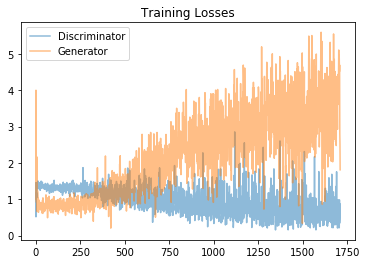

In [21]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

In [22]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [23]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

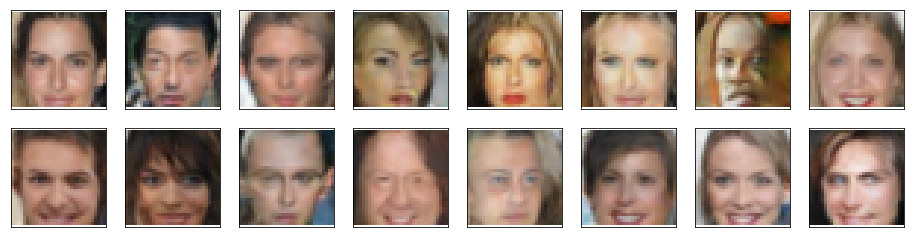

In [24]:
_ = view_samples(-1, samples)